In [24]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
import os

# Define the path to the folder containing the Parquet files
folder_path = 'data/CO2'  # Adjust this to your actual folder path

# List all Parquet files in the directory
parquet_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.parquet')]

# Read and concatenate all Parquet files into a single DataFrame
df_list = [pd.read_parquet(file) for file in parquet_files]
df = pd.concat(df_list, ignore_index=True)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df = df.sort_values(by='timestamp')
df['timestamp_local'] = df['timestamp'].dt.tz_localize('UTC').dt.tz_convert('Europe/Brussels')
df = df.sort_values('timestamp_local').set_index('timestamp_local')
df = df[df.index > '2025-01-03 19:00:00+01:00']

## Data filtering
# Calculate 20-minute moving average
df['co2_avg'] = df['co2_value'].rolling('30min', center=True).mean()
df['temperature_avg'] = df['temperature'].rolling('30min', center=True).mean()
df['humidity_avg'] = df['humidity'].rolling('30min', center=True).mean()

# Identify gaps in the time series data
gap_threshold = pd.Timedelta(minutes=1)
df['time_diff'] = df.index.to_series().diff()
df['is_gap'] = df['time_diff'] > gap_threshold

# Set CO2 values to pd.NA where there is a gap
df.loc[df['is_gap'], 'co2_value'] = pd.NA
df.loc[df['is_gap'], 'co2_avg'] = pd.NA

# Create figure
fig = make_subplots(specs=[[{"secondary_y": False}]])

# Add original CO2 data with gaps
fig.add_trace(
    go.Scatter(
        x=df.index, 
        y=df['co2_value'], 
        name='CO2 (ppm)', 
        line=dict(color='#00008B', width=1),
        connectgaps=False 
    ),
    secondary_y=False,
)

# Add moving average using filtered data (with NaNs)
fig.add_trace(
    go.Scatter(
        x=df.index, 
        y=df['co2_avg'], 
        name='30-min Moving Average', 
        line=dict(color='lightblue', width=2),
        connectgaps=False
    ),
    secondary_y=False,
)

# Update layout for better visualization and responsiveness
fig.update_layout(
    xaxis_title='Timestamp',
    yaxis_title='CO2 (ppm)',
    autosize=True,
    margin=dict(l=50, r=20, t=0, b=0),  # Adjusted margins
    plot_bgcolor='white',
    paper_bgcolor='white',
    showlegend=False,  # Remove legend from the plot
    font=dict(family="Arial, sans-serif", size=12))

# Add grid in light grey
fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='lightgrey')
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='lightgrey')

# Configuration for responsiveness
config = {
    'responsive': True,
    'displayModeBar': False,  # Hide the mode bar
    'scrollZoom': False  # Disable scroll zoom
}

# Save the figure as an HTML file
fig.write_html("./timeseries_co2_clean.html", config=config, include_plotlyjs='cdn', full_html=False)

# Show the figure (optional if running in a script)
fig.show(config=config)


In [103]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Assuming df_aggregated is already defined and contains your data
df_aggregated = df[['co2_avg', 'temperature_avg', 'humidity_avg']].resample('15min').mean()

# Calculate the rate of change for CO2 average
df_aggregated['co2_rate_of_change'] = df_aggregated['co2_avg'].diff(30)  # Calculate difference

def calculate_vapor_pressures(df_aggregated):
    """
    Calculate saturation vapor pressure (es) and actual vapor pressure (ea)
    based on average temperature and humidity.
    
    Parameters:
    df_aggregated (pd.DataFrame): DataFrame with 'temperature_avg' (in °C) and 'humidity_avg' (in %)
    
    Returns:
    pd.DataFrame: Original DataFrame with additional columns 'es' and 'ea' (in Pa)
    """
    # Constants
    e0 = 611  # Reference saturation vapor pressure at T0 (Pa)
    T0 = 273.15  # Reference temperature (K)
    L = 2.5e6  # Latent heat of vaporization (J/kg)
    Rv = 461.5  # Gas constant for water vapor (J/(kg·K))

    # Convert temperature to Kelvin
    T = df_aggregated['temperature_avg'] + 273.15

    # Calculate saturation vapor pressure (es) using Clausius-Clapeyron equation
    es = e0 * np.exp((L / Rv) * (1 / T0 - 1 / T))

    # Calculate actual vapor pressure (ea)
    ea = es * (df_aggregated['humidity_avg'] / 100)

    # Add new columns to the DataFrame
    df_aggregated['es'] = es
    df_aggregated['ea'] = ea

    return df_aggregated

df_aggregated = calculate_vapor_pressures(df_aggregated)
df_aggregated['temperature_K'] = df_aggregated['temperature_avg'] + 273.15
df_aggregated['total_water_vapor'] = df_aggregated['ea'] / df_aggregated['temperature_K']

# Create subplots with shared x-axis and separate y-axes
fig = make_subplots(rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.02)

# Add CO2 values trace without fill for NaN segments
fig.add_trace(
    go.Scatter(
        x=df_aggregated.index,
        y=df_aggregated['co2_avg'],
        mode='lines',
        name='CO2 (ppm)',
        line=dict(color='#00008B'),
        fill='tonexty',  # Fill under the curve only where there is data
        fillcolor='rgba(0, 0, 139, 0.05)'  # Light fill color (transparent blue)
    ),
    row=1, col=1
)

# Add Temperature trace without fill for NaN segments
fig.add_trace(
    go.Scatter(
        x=df_aggregated.index,
        y=df_aggregated['temperature_avg'],
        mode='lines',
        name='Temperature (°C)',
        line=dict(color='#FF0000'),
        fill='tonexty',  # Fill under the curve only where there is data
        fillcolor='rgba(255, 0, 0, 0.05)'  # Light fill color (transparent red)
    ),
    row=2, col=1
)

# Add Humidity trace without fill for NaN segments
fig.add_trace(
    go.Scatter(
        x=df_aggregated.index,
        y=df_aggregated['humidity_avg'],
        mode='lines',
        name='Humidity (%)',
        line=dict(color='#008000'),
        fill='tonexty',  # Fill under the curve only where there is data
        fillcolor='rgba(0, 128, 0, 0.05)'  # Light fill color (transparent green)
    ),
    row=3, col=1
)

# Add Rate of Change trace for CO2 average
fig.add_trace(
    go.Scatter(
        x=df_aggregated.index,
        y=df_aggregated['total_water_vapor'],
        mode='lines',
        name='Total water vapor',
        line=dict(color='#FFA500'),  # Orange color for visibility
    ),
    row=4, col=1
)

# Set y-axis limits based on min/max values for each subplot
fig.update_yaxes(title_text="CO2 (ppm)", range=[df_aggregated['co2_avg'].min(), df_aggregated['co2_avg'].max()], row=1, col=1)
fig.update_yaxes(title_text="Temperature (°C)", range=[df_aggregated['temperature_avg'].min(), df_aggregated['temperature_avg'].max()], row=2, col=1)
fig.update_yaxes(title_text="Humidity (%)", range=[df_aggregated['humidity_avg'].min(), df_aggregated['humidity_avg'].max()], row=3, col=1)
fig.update_yaxes(title_text="Rate of Change (ppm/min)", row=4, col=1)  # Title for rate of change

# Update layout for better visualization
fig.update_layout(
    height=1000,
    width=1200,
    plot_bgcolor='white',
    showlegend=True  # Show legend to identify traces
)

# Add grid in light grey
fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='lightgrey')

# Show the figure (optional if running in a script)
fig.show()


In [93]:
# Create figure
fig = make_subplots(specs=[[{"secondary_y": False}]])

fig.add_trace(
    go.Scatter(
        x=df_aggregated.index, 
        y=df_aggregated['total_water_vapor'], 
        name='Actual vapor pressure (Pa)', 
        line=dict(color='#008000', width=1),
        connectgaps=False 
    ),
    secondary_y=False,
)


# Update layout
fig.update_layout(
    xaxis_title='Timestamp',
    yaxis_title='Actual vapor pressure (Pa)',
    legend_title_text='',
    width=1000,
    height=500
)

fig.show()

In [94]:
# Create figure
fig = make_subplots(specs=[[{"secondary_y": False}]])

# Add original CO2 data with gaps
fig.add_trace(
    go.Scatter(
        x=df.index, 
        y=df['humidity'], 
        name='Relative Humidity (%)', 
        line=dict(color='#008000', width=1),
        connectgaps=False 
    ),
    secondary_y=False,
)

# Add moving average using filtered data (with NaNs)
fig.add_trace(
    go.Scatter(
        x=df.index, 
        y=df['humidity_avg'], 
        name='Smooth Relative Humidity (%)', 
        line=dict(color='lightblue', width=2),
        connectgaps=False
    ),
    secondary_y=False,
)

# Add moving average using filtered data (with NaNs)
fig.add_trace(
    go.Scatter(
        x=df_aggregated.index, 
        y=df_aggregated['humidity_avg'], 
        name='Smooth Relative Humidity (%)', 
        line=dict(color='black', width=2),
        connectgaps=False
    ),
    secondary_y=False,
)

# Update layout
fig.update_layout(
    xaxis_title='Timestamp',
    yaxis_title='Relative Humidity (%)',
    legend_title_text='',
    width=1000,
    height=500
)

fig.show()

/var/folders/j9/wxzkbfkj0zz0zthrb7j4hjsr0000gn/T/ipykernel_65074/4286988298.py:24: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/j9/wxzkbfkj0zz0zthrb7j4hjsr0000gn/T/ipykernel_65074/4286988298.py:28: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



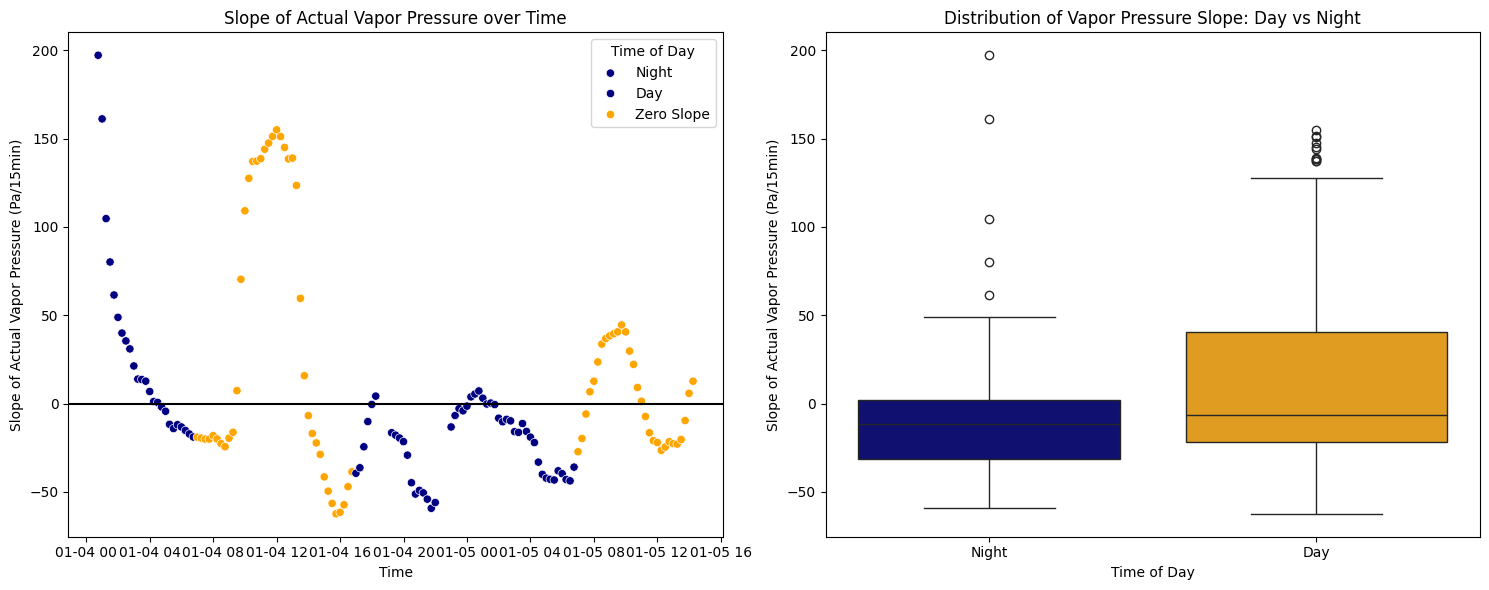

T-statistic: 3.001905577207312
P-value: 0.0031672181385499136
Mean slope during day: 21.9960
Mean slope during night: -5.3556
The difference in average slope between day and night is statistically significant.


In [95]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

# Calculate the 1-hour difference in actual vapor pressure
df_aggregated['ea_slope'] = df_aggregated['ea'].diff(periods=15)  # Assuming 15-minute intervals

# Assuming df_aggregated has a 'timestamp_local' column
df_aggregated['is_day'] = df_aggregated.index.hour.isin(range(7, 17))

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Scatterplot
sns.scatterplot(x=df_aggregated.index, y='ea_slope', hue='is_day', data=df_aggregated, palette=['navy', 'orange'], ax=ax1)
ax1.set_title('Slope of Actual Vapor Pressure over Time')
ax1.set_xlabel('Time')
ax1.set_ylabel('Slope of Actual Vapor Pressure (Pa/15min)')
ax1.legend(title='Time of Day', labels=['Night', 'Day', 'Zero Slope'])
ax1.axhline(y=0, color='black', linestyle='-', label='Zero Slope')

# Boxplot
sns.boxplot(x='is_day', y='ea_slope', data=df_aggregated, palette=['navy', 'orange'], ax=ax2)
ax2.set_title('Distribution of Vapor Pressure Slope: Day vs Night')
ax2.set_xlabel('Time of Day')
ax2.set_ylabel('Slope of Actual Vapor Pressure (Pa/15min)')
ax2.set_xticklabels(['Night', 'Day'])

plt.tight_layout()
plt.show()

# Perform t-test
day_slope = df_aggregated[df_aggregated['is_day']]['ea_slope'].dropna()
night_slope = df_aggregated[~df_aggregated['is_day']]['ea_slope'].dropna()

t_stat, p_value = stats.ttest_ind(day_slope, night_slope)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")
print(f"Mean slope during day: {day_slope.mean():.4f}")
print(f"Mean slope during night: {night_slope.mean():.4f}")

if p_value < 0.05:
    print("The difference in average slope between day and night is statistically significant.")
else:
    print("There is no statistically significant difference in average slope between day and night.")

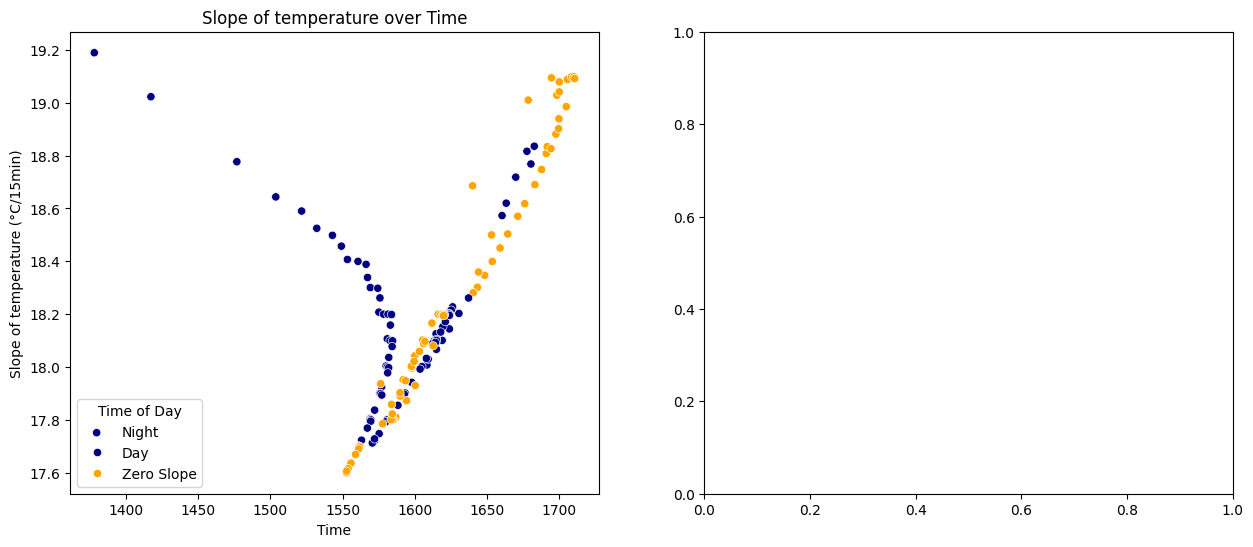

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

# Calculate the 1-hour difference in actual vapor pressure
df_aggregated['temp_slope'] = df_aggregated['temperature_avg'].diff(periods=15)  # Assuming 15-minute intervals

# Assuming df_aggregated has a 'timestamp_local' column
df_aggregated['is_day'] = df_aggregated.index.hour.isin(range(7, 17))

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Scatterplot
sns.scatterplot(x='ea', y='temperature_avg', hue='is_day', data=df_aggregated, palette=['navy', 'orange'], ax=ax1)
ax1.set_title('Slope of temperature over Time')
ax1.set_xlabel('Time')
ax1.set_ylabel('Slope of temperature (°C/15min)')
ax1.legend(title='Time of Day', labels=['Night', 'Day', 'Zero Slope'])

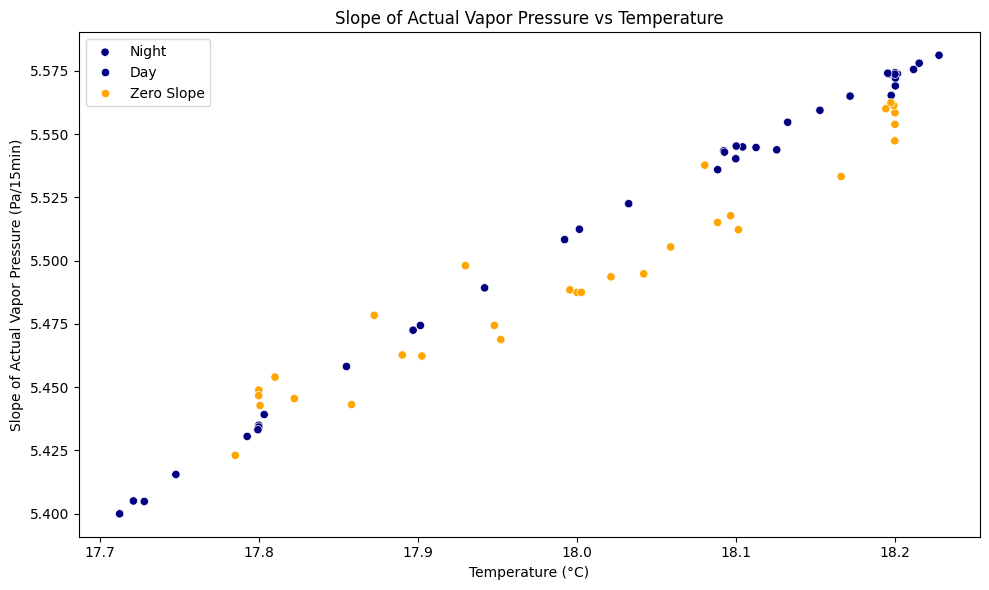

In [79]:
# Scatterplot
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.scatterplot(x='temperature_avg', y='total_water_vapor', hue='is_day', data=df_aggregated, palette=['navy', 'orange'], ax=ax1)
ax1.set_title('Slope of Actual Vapor Pressure vs Temperature')
ax1.set_xlabel('Temperature (°C)')
ax1.set_ylabel('Slope of Actual Vapor Pressure (Pa/15min)')
ax1.legend(title='Time of Day', labels=['Night', 'Day'])
#ax1.axhline(y=0, color='black', linestyle='-', label='Zero Slope')
ax1.legend(title='', labels=['Night', 'Day', 'Zero Slope'])
plt.tight_layout()
plt.show()


In [56]:
def categorize_day_night(timestamp):
    if timestamp.hour >= 7 and timestamp.hour < 18:
        return 'Day'
    else:
        return 'Night'

# Apply the function to create a new column
df_aggregated['Day_Night'] = df_aggregated.index.to_series().apply(categorize_day_night)

# Display the updated DataFrame
df_aggregated

co2_avg  temperature_avg  humidity_avg  \
timestamp_local                                                        
2025-01-04 09:00:00+01:00  710.635427        17.600000     76.501748   
2025-01-04 09:15:00+01:00  707.705166        17.606145     76.479148   
2025-01-04 09:30:00+01:00  711.040362        17.936966     76.014296   
2025-01-04 09:45:00+01:00  731.848163        18.685924     75.395584   
2025-01-04 10:00:00+01:00  746.558314        19.010294     75.593155   
...                               ...              ...           ...   
2025-01-05 13:15:00+01:00  400.462495        18.002778     76.716666   
2025-01-05 13:30:00+01:00  400.646978        18.021433     76.716003   
2025-01-05 13:45:00+01:00  400.665429        18.058974     76.706685   
2025-01-05 14:00:00+01:00  400.688249        18.088504     76.704645   
2025-01-05 14:15:00+01:00  400.814106        18.096679     76.703583   

                           co2_rate_of_change           es           ea  \
timestamp_local                                                           
2025-01-04 09:00:00+01:00                 NaN  2029.594087  1552.674957   
2025-01-04 09:15:00+01:00                 NaN  2030.393468  1552.827617   
2025-01-04 09:30:00+01:00                 NaN  2073.844010  1576.417925   
2025-01-04 09:45:00+01:00                 NaN  2175.294218  1640.075774   
2025-01-04 10:00:00+01:00                 NaN  2220.589189  1678.613424   
...                                       ...          ...          ...   
2025-01-05 13:15:00+01:00          -27.577177  2082.586178  1597.690675   
2025-01-05 13:30:00+01:00          -23.886542  2085.070262  1599.582573   
2025-01-05 13:45:00+01:00          -21.618138  2090.077136  1603.228889   
2025-01-05 14:00:00+01:00          -18.362972  2094.022954  1606.212874   
2025-01-05 14:15:00+01:00          -15.326839  2095.116546  1607.029450   

                           is_day   ea_slope Day_Night  
timestamp_local                                         
2025-01-04 09:00:00+01:00    True        NaN       Day  
2025-01-04 09:15:00+01:00    True        NaN       Day  
2025-01-04 09:30:00+01:00    True        NaN       Day  
2025-01-04 09:45:00+01:00    True        NaN       Day  
2025-01-04 10:00:00+01:00    True        NaN       Day  
...                           ...        ...       ...  
2025-01-05 13:15:00+01:00    True -22.903485       Day  
2025-01-05 13:30:00+01:00    True -20.307755       Day  
2025-01-05 13:45:00+01:00    True  -9.536556       Day  
2025-01-05 14:00:00+01:00    True   5.839087       Day  
2025-01-05 14:15:00+01:00    True  12.693420       Day  

[118 rows x 9 columns]

co2_avg: F-statistic = 6.99, p-value = 0.0093
temperature_avg: F-statistic = 16.75, p-value = 0.0001
humidity_avg: F-statistic = 9.13, p-value = 0.0031
co2_rate_of_change: F-statistic = 153.58, p-value = 0.0000


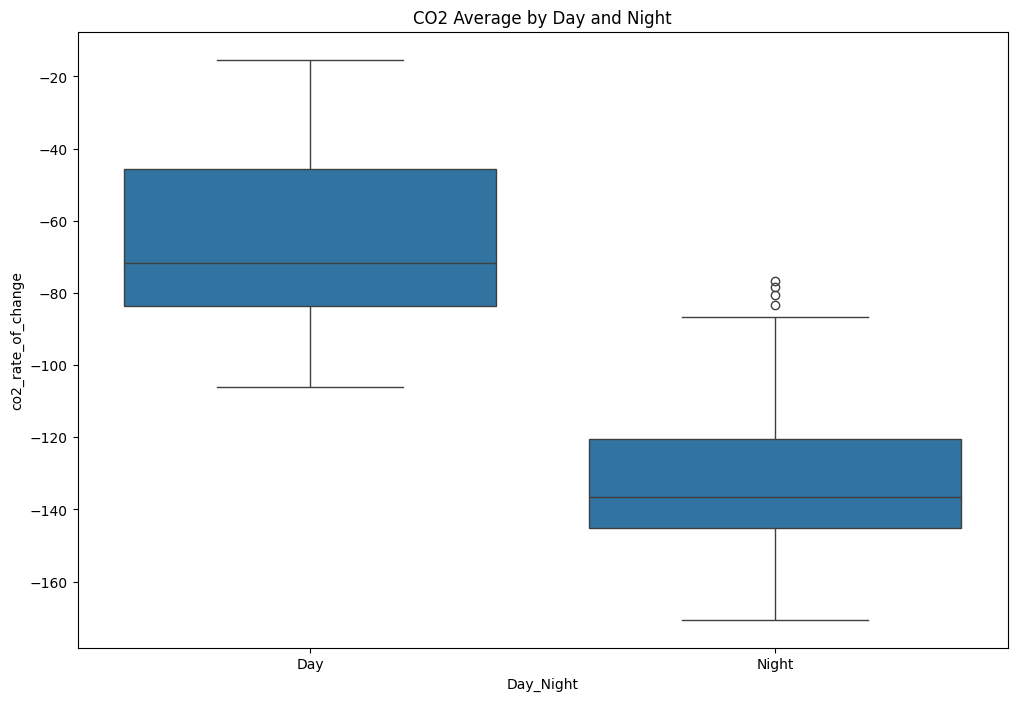

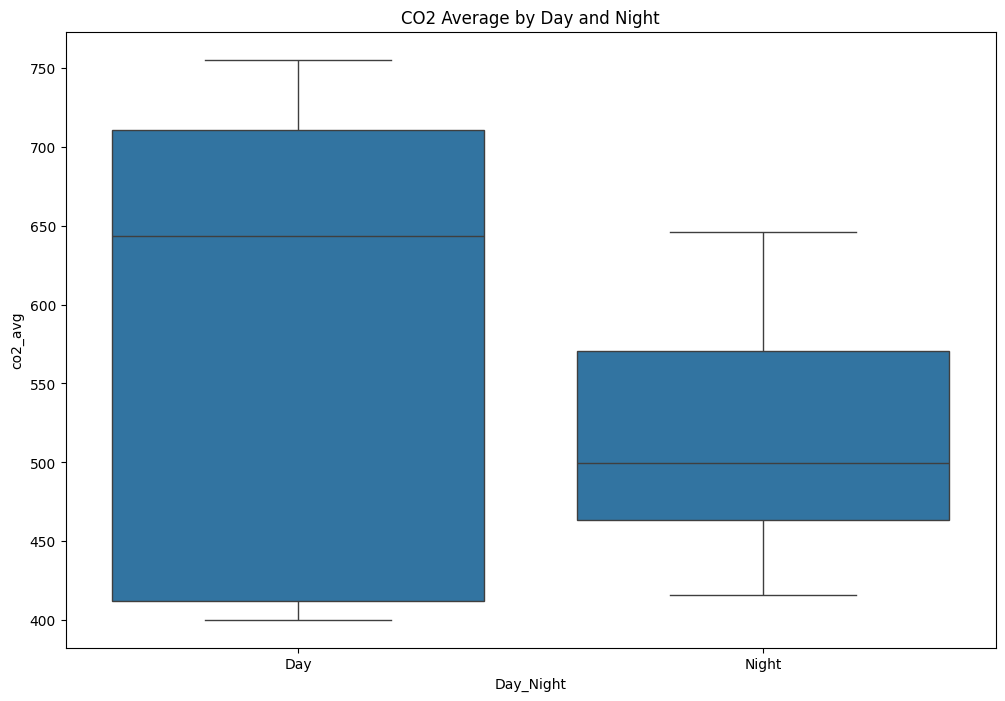

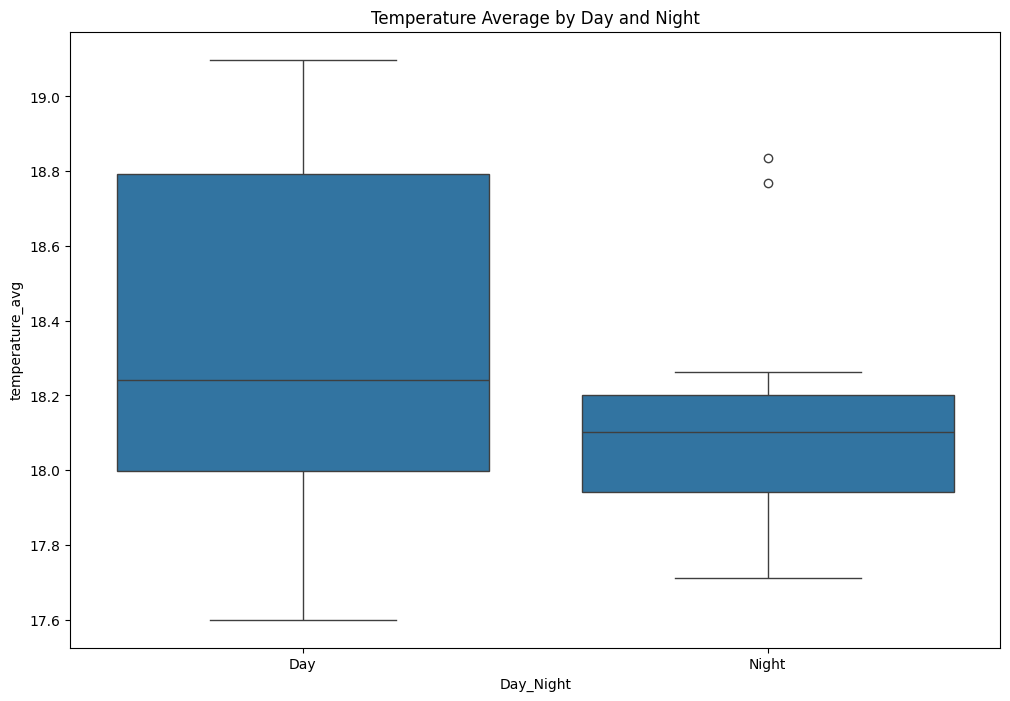

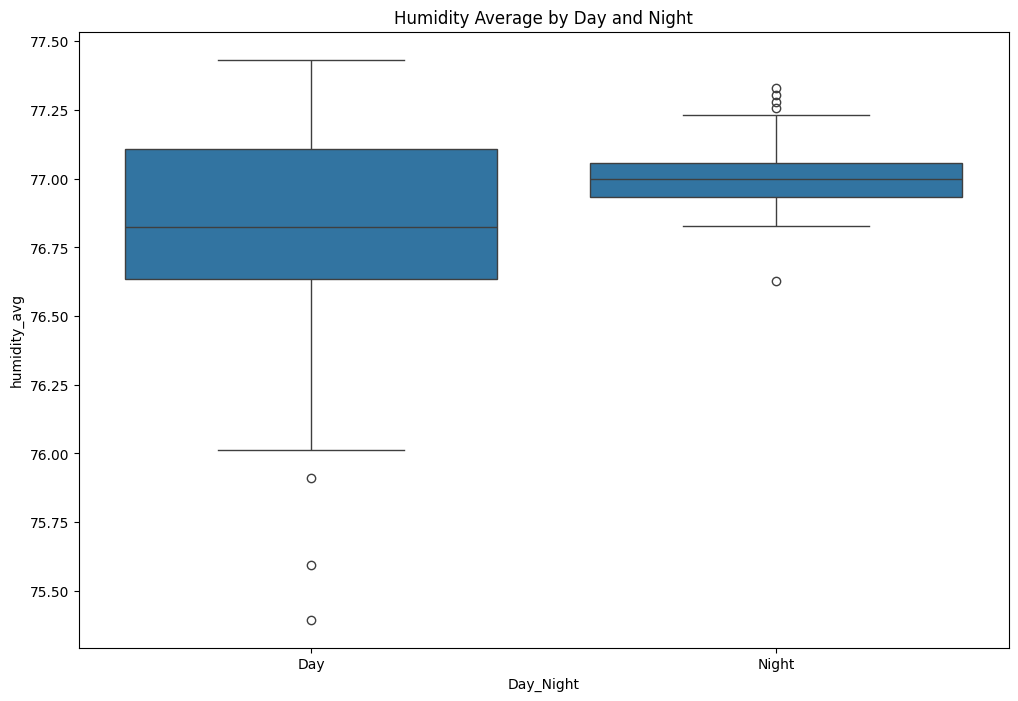

In [57]:
from scipy import stats
import matplotlib.pyplot as plt

# Perform ANOVA for each variable
anova_results = {}
for column in ['co2_avg', 'temperature_avg', 'humidity_avg', 'co2_rate_of_change']:
    day_data = df_aggregated[df_aggregated['Day_Night'] == 'Day'][column]
    night_data = df_aggregated[df_aggregated['Day_Night'] == 'Night'][column]
    
    # Perform ANOVA
    f_stat, p_value = stats.f_oneway(day_data.dropna(), night_data.dropna())
    anova_results[column] = {'F-statistic': f_stat, 'p-value': p_value}

# Print ANOVA results
for variable, result in anova_results.items():
    print(f"{variable}: F-statistic = {result['F-statistic']:.2f}, p-value = {result['p-value']:.4f}")

# Create boxplots for visualization
plt.figure(figsize=(12, 8))
sns.boxplot(x='Day_Night', y='co2_rate_of_change', data=df_aggregated)
plt.title('CO2 Average by Day and Night')
plt.show()

# Create boxplots for visualization
plt.figure(figsize=(12, 8))
sns.boxplot(x='Day_Night', y='co2_avg', data=df_aggregated)
plt.title('CO2 Average by Day and Night')
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(x='Day_Night', y='temperature_avg', data=df_aggregated)
plt.title('Temperature Average by Day and Night')
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(x='Day_Night', y='humidity_avg', data=df_aggregated)
plt.title('Humidity Average by Day and Night')
plt.show()